In [24]:
import pandas as pd

In [25]:
scores_scaling_df = pd.read_csv("alignment_scores_scaling.csv")

In [26]:
scores_scaling_df.head()

,Combination,Checkpoint,Score
0,1.4b-160m,step0,0.290711
1,14m-1b,step0,0.291078
2,14m-160m,step0,0.287683
3,14m-410m,step0,0.304105
4,1.4b-70m,step0,0.285505


Cleaned DataFrame:
  Combination Checkpoint     Score  step Model_A Model_B
0   1.4b-160m      step0  0.290711     0    1.4b    160m
1      14m-1b      step0  0.291078     0     14m      1b
2    14m-160m      step0  0.287683     0     14m    160m
3    14m-410m      step0  0.304105     0     14m    410m
4    1.4b-70m      step0  0.285505     0    1.4b     70m

Mean Alignment Scores for Model 14m:
      step     Score
0        0  0.297454
1     1000  0.378658
2     8000  0.419989
3    15000  0.454077
4    22000  0.427970
5    29000  0.397672
6    36000  0.402305
7    43000  0.411451
8    50000  0.390900
9    57000  0.379444
10   64000  0.308194
11   71000  0.307173
12   78000  0.225763
13   85000  0.184197
14   92000  0.265642
15   99000  0.250751
16  106000  0.241743
17  113000  0.273360
18  120000  0.254725
19  127000  0.293440
20  134000  0.267649
21  141000  0.296491
22  143000  0.260011

Mean Alignment Scores for Model 160m:
      step     Score
0        0  0.294465
1     1000  0.44

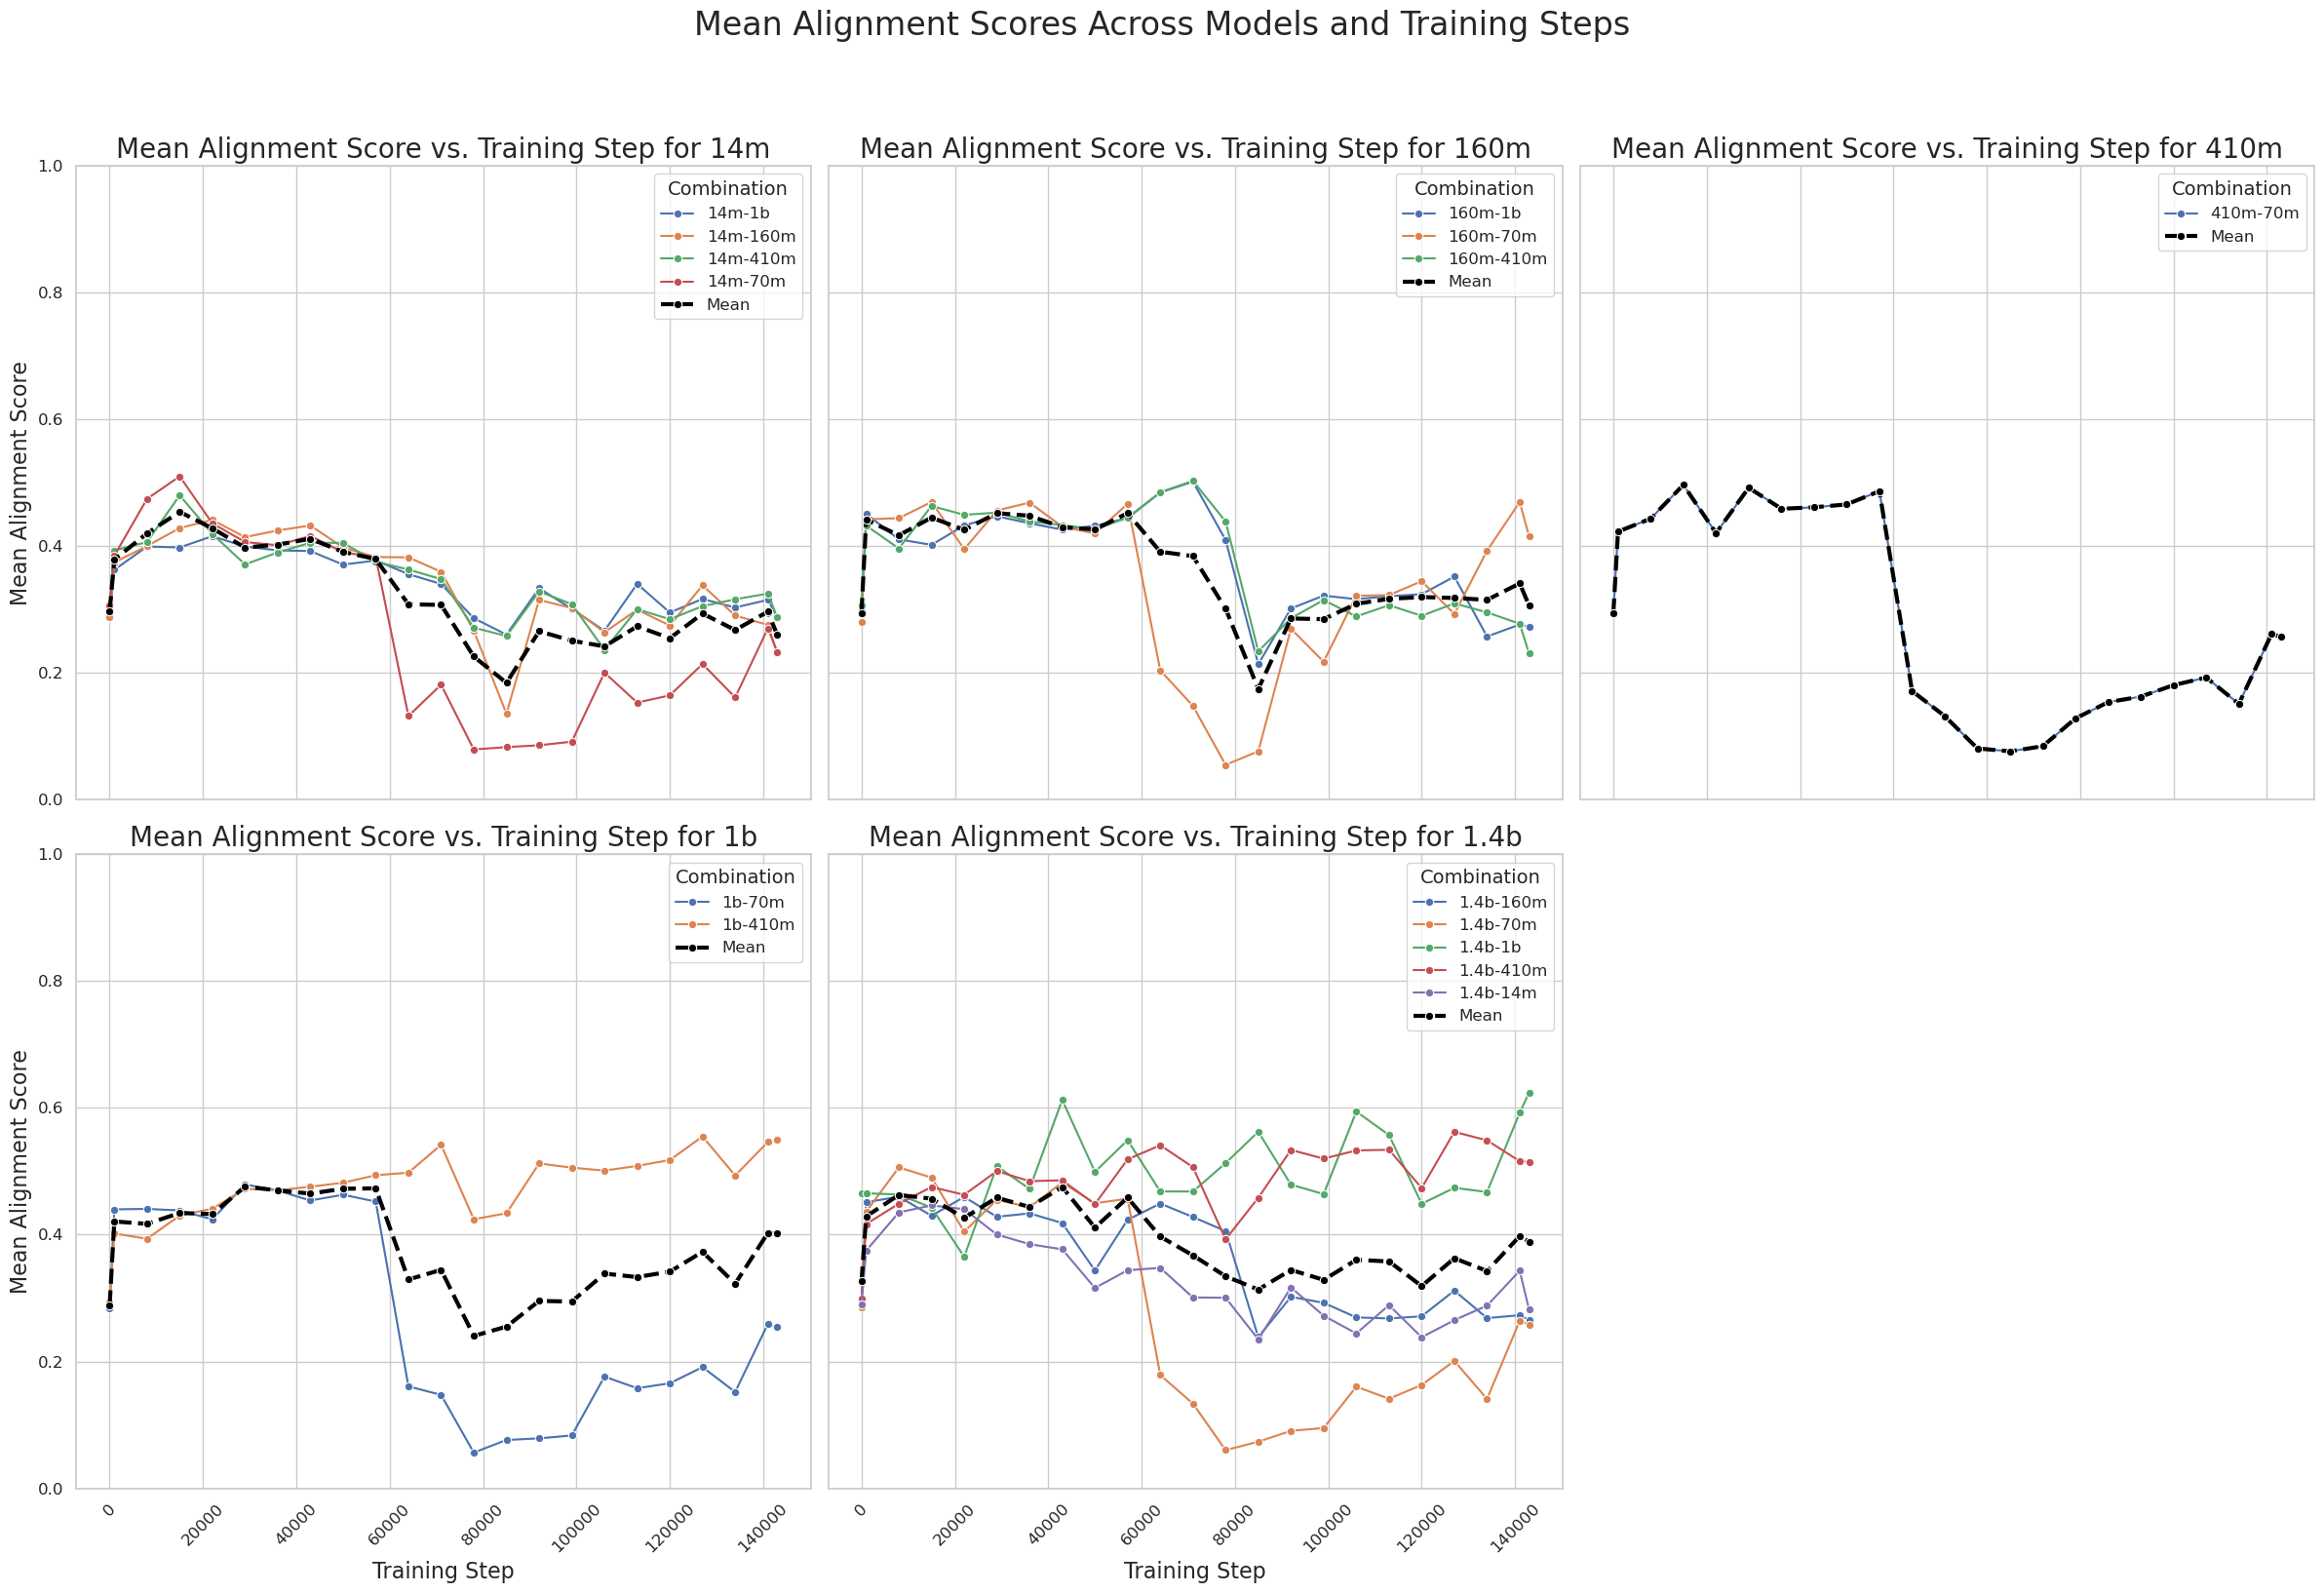

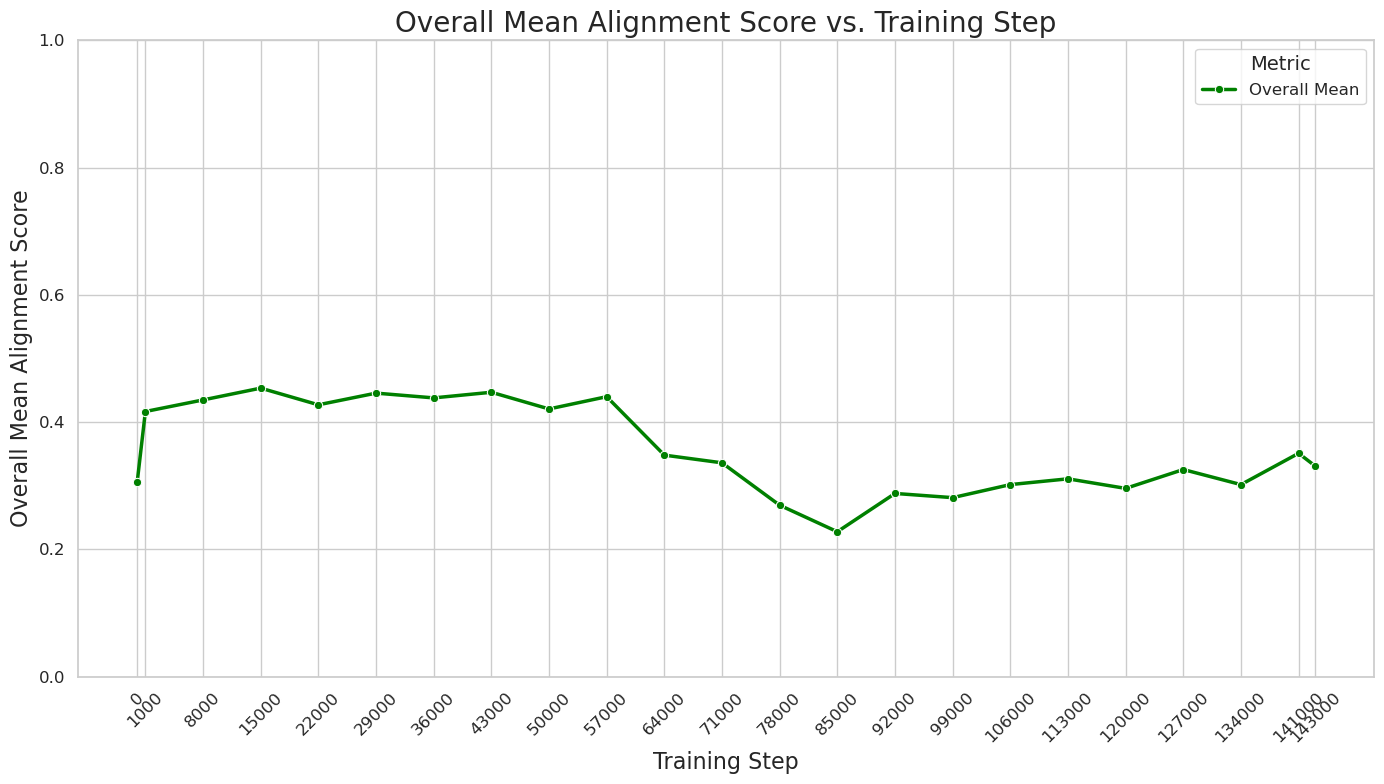

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# -------------------- Step 1: Data Cleaning --------------------

# 1.1 Remove 'step' prefix and convert 'Checkpoint' to numerical step
scores_scaling_df['step'] = scores_scaling_df['Checkpoint'].str.replace('step', '', regex=False).astype(int)

# 1.2 Extract 'Model_A' and 'Model_B' from 'Combination' by splitting the string at the '-' character
scores_scaling_df[['Model_A', 'Model_B']] = scores_scaling_df['Combination'].str.split('-', expand=True)

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
print(scores_scaling_df.head())

# -------------------- Step 2: Compute Mean Alignment Scores --------------------

# Define the ordered list of models
ordered_models = ['14m', '160m', '410m', '1b', '1.4b']

# Initialize a dictionary to hold mean scores for each model
mean_scores_dict = {}

# Iterate over each model and compute the mean alignment score at each step
for model in ordered_models:
    # Filter rows where 'Model_A' is the current model
    model_df = scores_scaling_df[scores_scaling_df['Model_A'] == model]
    
    if model_df.empty:
        print(f"No data found for model {model}. Skipping.")
        continue
    
    # Group by 'step' and compute the mean 'Score'
    mean_scores = model_df.groupby('step')['Score'].mean().reset_index()
    
    # Store in the dictionary
    mean_scores_dict[model] = mean_scores
    
    # Display the mean scores for the current model
    print(f"\nMean Alignment Scores for Model {model}:")
    print(mean_scores)

# -------------------- Step 3: Compute Overall Mean Alignment Scores --------------------

# 3.1 Compute the overall mean alignment score across all combinations at each step
overall_mean_scores = scores_scaling_df.groupby('step')['Score'].mean().reset_index()

# Display the overall mean scores
print("\nOverall Mean Alignment Scores:")
print(overall_mean_scores)

# -------------------- Step 4: Visualization --------------------

# Set the visual style for the plots
sns.set(style="whitegrid")

# -------------------- Step 4.1: Plot Mean Alignment Scores per Model --------------------

# Create a figure with 6 subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over

for idx, model in enumerate(ordered_models):
    ax = axes[idx]
    
    # Check if mean_scores_dict contains data for the current model
    if model not in mean_scores_dict:
        ax.set_title(f'Mean Alignment Score vs. Training Step for {model} (No data)', fontsize=18)
        ax.axis('off')  # Hide the subplot if no data
        continue
    
    # Filter data for the current model
    model_data = scores_scaling_df[scores_scaling_df['Model_A'] == model]
    
    # Get unique Model_B values for the current Model_A
    model_bs = model_data['Model_B'].unique()
    
    # Plot each combination's alignment score
    for model_b in model_bs:
        comb_data = model_data[model_data['Model_B'] == model_b]
        sns.lineplot(
            data=comb_data,
            x='step',
            y='Score',
            marker='o',
            ax=ax,
            label=f"{model}-{model_b}"
        )
    
    # Compute mean alignment score per step
    mean_scores = mean_scores_dict[model]
    
    # Plot the mean curve
    sns.lineplot(
        data=mean_scores,
        x='step',
        y='Score',
        marker='o',
        ax=ax,
        label='Mean',
        linewidth=3,
        linestyle='--',
        color='black'
    )
    
    # Set plot title and labels
    ax.set_title(f'Mean Alignment Score vs. Training Step for {model}', fontsize=20)
    ax.set_xlabel('Training Step', fontsize=16)
    ax.set_ylabel('Mean Alignment Score', fontsize=16)
    
    # Improve x-axis labels by rotating them if there are many steps
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Set y-axis limits based on your data
    ax.set_ylim(0, 1)  # Adjust this based on the range of your alignment scores
    
    # Add gridlines for better readability
    ax.grid(True)
    
    # Adjust legend to fit inside the plot
    ax.legend(title='Combination', fontsize=12, title_fontsize=14, loc='upper right')

# Remove any unused subplots if the number of models is less than the number of subplots
for i in range(len(ordered_models), len(axes)):
    fig.delaxes(axes[i])

# Add a main title to the entire figure
plt.suptitle('Mean Alignment Scores Across Models and Training Steps', fontsize=24, y=1.02)

# Adjust layout to prevent overlapping of subplots and titles
plt.tight_layout()

# Adjust the spacing to accommodate the main title
plt.subplots_adjust(top=0.92)

# Display the plots
plt.show()

# -------------------- Step 4.2: Plot Overall Mean Alignment Score --------------------

# Create a separate figure for the overall mean alignment score
plt.figure(figsize=(14, 8))

# Plot the overall mean alignment score over steps
sns.lineplot(
    data=overall_mean_scores,
    x='step',
    y='Score',
    marker='o',
    color='green',
    linewidth=2.5,
    label='Overall Mean'
)

# Set plot title and labels
plt.title('Overall Mean Alignment Score vs. Training Step', fontsize=20)
plt.xlabel('Training Step', fontsize=16)
plt.ylabel('Overall Mean Alignment Score', fontsize=16)

# Improve x-axis labels by rotating them if there are many steps
plt.xticks(overall_mean_scores['step'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis limits based on your data
plt.ylim(0, 1)  # Adjust this based on the range of your alignment scores

# Add gridlines for better readability
plt.grid(True)

# Add legend
plt.legend(title='Metric', fontsize=12, title_fontsize=14)

# Adjust layout to prevent clipping of labels and ensure everything fits well
plt.tight_layout()

# Add a main title to the entire figure
plt.title('Overall Mean Alignment Score vs. Training Step', fontsize=20)

# Display the plot
plt.show()

# -------------------- Optional: Save the Plots --------------------
# Uncomment the following lines if you wish to save each plot as an image file.

# 4.1: Save the 6 separate plots
# fig.savefig('mean_alignment_scores_per_model.png', dpi=300, bbox_inches='tight')
# print("Mean alignment scores per model plot saved as 'mean_alignment_scores_per_model.png'.")

# 4.2: Save the overall mean plot
# plt.figure(figsize=(14, 8))
# sns.lineplot(
#     data=overall_mean_scores,
#     x='step',
#     y='Score',
#     marker='o',
#     color='green',
#     linewidth=2.5,
#     label='Overall Mean'
# )
# plt.title('Overall Mean Alignment Score vs. Training Step', fontsize=20)
# plt.xlabel('Training Step', fontsize=16)
# plt.ylabel('Overall Mean Alignment Score', fontsize=16)
# plt.xticks(overall_mean_scores['step'], rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.ylim(0, 1)  # Adjust this based on the range of your alignment scores
# plt.grid(True)
# plt.legend(title='Metric', fontsize=12, title_fontsize=14)
# plt.tight_layout()
# plt.savefig('overall_mean_alignment_score.png', dpi=300)
# print("Overall mean alignment score plot saved as 'overall_mean_alignment_score.png'.")
